Hello! Here I test RL on a gridworld. In a gridworld an agent needs to get to a goal while obstacles lie in it's way. Here I use walls as the obstacle. The agent uses Table Lookup SARSA(lambda). To start run the cells until the next message comes up

In [1]:
# Import Statements
import sys 
import os
sys.path.append(os.path.abspath('..'))
import numpy as np
import pygame
from pygame.locals import *
import matplotlib.pyplot as plt
from Common_functions import file_io, pygame_visuals as pv
from sys import exit

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
# RL algorithm
# If you are going to adjust the agents parameters view the documentation in __init__() to understand what each does.

class sarsa():
    """
    Uses table lookup backward view SARSA(lambda) to learn. States are represented with with natural numbers. Same for actions.
    
    Game Loop should look like:
    Get first action (baction, bstate)
    Repeat until terminal state
      take the action   (reward)
      update env (nstate)
      get action    (naction)
      update agent (bstate, baction <-- nstate, naction)
    """
    
    def __init__(self, gamma, alpha, epsilon, min_epsilon, lamda, num_states, num_actions):
        """
        Initalizes agent. 
        
        Params: 
        gamma:       disount factor. How much it cares about the future. [0,1]
        alpha:       step size rate. How much it updates current prediction towards new one. [0,1]
        epsilon:     exploration rate. How often it makes random moves. [0,1]
        min_epsilon: lower bound on epsilon. [0,1]
        lamda:       weight of n-step return. [0,1]
        ...
        """
        #Learning parameters
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.lamda = lamda
        
        #Field variables
        self.num_states = num_states
        self.num_actions = num_actions
        self.q_table = np.random.randn(num_states, num_actions)
        self.not_min_epsilon = True
        
        #Resetables 
        self.eligibility = np.zeros((num_states, num_actions))
        self.bstate = None
        self.baction = None
        
    def reset(self):
        self.bstate = None
        self.baction = None
        self.eligibility = np.zeros((self.num_states, self.num_actions))

    def set_init_values(self, state, action):
        self.bstate = state
        self.baction = action
        
    def q_value(self, state, action):
        return self.q_table[state][action]
    
    def choose_action(self, state):
        """
        Returns action given state. Both are represented as whole numbers
        
        Params:
        state:   whole number corresponding to state
        """
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(0,self.num_actions)
        else:
            actions = [self.q_value(state, ac) for ac in range(self.num_actions)]
            return actions.index(max(actions))
            
    def update(self, state, action, reward, debug = False):
        
        if debug: #
            print("new update")
            
        sarsa_error = self.q_table[state][action] + reward - self.q_table[self.bstate][self.baction]
    
        if debug: #
            print('bstate', self.bstate, 'baction', self.baction, 'reward', reward, 'state', state, 'action', action)
            print('error', sarsa_error)
            
        
        self.eligibility *= self.lamda*self.gamma
        self.eligibility[self.bstate][self.baction] += 1
            
        if debug: #
            print(self.q_table[:3])
                
        #self.q_table[self.bstate][self.baction] +=  self.alpha*sarsa_error* self.eligibility[self.bstate][self.baction]
        self.q_table +=  self.alpha*sarsa_error* self.eligibility
        
        if debug: #
            print(self.q_table[:3])
                
        if self.not_min_epsilon: 
            self.epsilon *= 0.99999
            if self.epsilon <= 0.1:
                self.not_min_epsilon = False
                    
        self.bstate, self.baction = state, action
                   
    def save(self, filename = 'agent.txt'):
        
        with open(filename, mode = 'w') as file:
            file.write(str(self.gamma) + " " + str(self.alpha) + " " + str(self.epsilon) + " " + str(self.min_epsilon) + " ")
            file.write(str(self.lamda) + " " + str(self.num_states) + " " + str(self.num_actions) + " "+ str(self.not_min_epsilon))
            file.write("\n\n" + str(self.q_table))
            
    def load(self, filename = 'agent.txt'):
        
        with open(filename, mode = 'r') as file:
            sarsa_string = file.read()
            params, q_table = sarsa_string.split("\n\n")
            params_list = params.split(" ")
            
            self.gamma, self.alpha, self.epsilon, self.min_epsilon, self.lamda = [float(val) for val in params_list[:5]]
            self.num_states, self.num_actions = [int(val) for val in params_list[5:7]]
            self.not_min_epsilon = bool(params_list[7])
            
            self.q_table = np.array(file_io.from_twodim_nparr(q_table))
            self.reset()
            

In [3]:
# Environment

class gridworld:
    def __init__(self, cs, blocks, playerx, playery, goalx, goaly, wall_coords = [], vision = 5):
        self.init_player = pygame.Rect(playerx,playery,cs,cs)
        self.player = self.init_player
        self.goal = pygame.Rect(goalx, goaly, cs,cs)
        self.wall = []
        for coord in wall_coords:
            self.wall.append(pygame.Rect(coord[0], coord[1], cs, cs))
        
        self.cs = cs
        self.blocks = blocks
        self.end = (1+blocks)*cs
        self.move = []
        
        self.vision = vision
        self.feature_size = vision**2+2
        self.shift = int(vision/2)
        self.vision_player_index = 2+(1+self.vision)*self.shift
        
        self.terminal = False
        
        self.reward = 0
        self.score = 0
    
    def rect_to_list(rect):
        return [rect.topleft[0], rect.topleft[1], rect.size[0], rect.size[1]]
        
    def save(self, filename = 'map.txt'):
        
        with open(filename, mode = 'w') as file:
            file.write(str(self.cs) + " " + str(self.blocks) + " " + str(self.vision) + "\n")
            file.write(str(gridworld.rect_to_list(self.init_player)) + "\n")
            file.write(str(gridworld.rect_to_list(self.goal)) + "\n")
            file.write(str([gridworld.rect_to_list(w) for w in self.wall]))


    
    def load(self, filename = 'map.txt'):
        
        with open(filename, mode = 'r') as file:
            gw_string = file.read()
            params, player, goal, walls = gw_string.split("\n")
            self.cs, self.blocks, self.vision = [int(val) for val in params.split(" ")]
            self.init_player = pygame.Rect(file_io.from_onedim_list(player, dtype = int))
            self.goal = pygame.Rect(file_io.from_onedim_list(goal, dtype = int))
            
            for rect in file_io.from_twodim_list(walls, dtype = int):
                self.wall.append(pygame.Rect(rect))
        
        self.player = self.init_player
        
        self.end = (1+self.blocks)*self.cs

        self.feature_size = self.vision**2+2
        self.shift = int(self.vision/2)
        self.vision_player_index = 2+6*self.shift
        
    def reset(self):
        self.player = self.init_player
        self.terminal = False
        self.reward = 0
        self.score = 0    
    
    def make_gridworld(self):
        
        pygame.init()
        self.reset()
        pygame.display.set_caption('Gridworld Creator')
        gameDisplay = pygame.display.set_mode((800,600))
        mode = 'wall'
        color = (0,0,255)
        mousecoor = (1000,1000)
        directions = pv(gameDisplay, text_color = (255,255,255))
        directions.add_message(topleft = (self.end+10, self.cs))
        directions.add_message(topleft = (self.end+10, 2*self.cs))
        directions.add_message(topleft = (self.end+10, 3*self.cs))
        directions.add_message(topleft = (self.end+10, 4*self.cs))
        
        run = True
        while run: 
            for event in pygame.event.get():
                if event.type == QUIT:
                    pygame.quit()
                    exit()
                elif event.type == KEYDOWN:
                    if event.key == pygame.K_SPACE:
                        run = False
                    elif event.key == pygame.K_w:
                        mode = 'wall'
                        color = (0,0,255)
                    elif event.key == pygame.K_p:
                        mode = 'player'
                        color = (255,0,0)
                    elif event.key == pygame.K_g:
                        mode = 'goal'
                        color = (0,255,0)
                        
                elif event.type == MOUSEBUTTONDOWN:
                    xmouse, ymouse = event.pos
                    
                    if xmouse < self.end or xmouse >= self.cs:
                        if ymouse < self.end or ymouse >= self.cs:
                            x = int(xmouse/self.cs)*self.cs
                            y = int(ymouse/self.cs)*self.cs
                            test_rect = pygame.Rect(x, y, self.cs, self.cs)
                            if mode == 'wall':
                                if test_rect in self.wall:
                                    self.wall.remove(test_rect)
                                else:
                                    self.wall.append(test_rect)
                            elif mode == 'player':
                                self.init_player = test_rect
                                self.player = test_rect
                            elif mode == 'goal':
                                self.goal = test_rect
                            
                elif event.type == MOUSEMOTION:
                    mousecoor = event.pos 
                
            gameDisplay.fill((0,0,0))
            pygame.draw.circle(gameDisplay, color, mousecoor, 5)
            self.draw(gameDisplay, False)
            pv.show_text(gameDisplay, 'Mode is ' + str(mode), topleft = (self.cs, self.end), fontsize = 20, priority = 0)
            directions.show_all_messages("Click any square to edit it", "Press w to go to wall edit mode", 
                                         "Press p to go to player edit mode", "Press g to go to goal edit mode")
            pygame.display.update()
    
            pygame.time.wait(50)
        pygame.quit()
        
    
    def set_movement(self, choice):
        if choice == 0:
            self.move = [self.cs,0]
        elif choice == 1:
            self.move = [0,self.cs]
        elif choice == 2:
            self.move = [-self.cs,0]
        elif choice == 3:
            self.move = [0,-self.cs]
            
    def return_feature(self, action):       
        # If you are reading this part you have discovered a method that isn't used but sheds light into the parameters 
        # of the linear function approximator!
        
        feature = np.zeros(self.feature_size) # Vision = self.vision by self.vision + the xdist and ydist to goal
        
        original_move = self.move.copy()
        self.set_movement(action)
        
        topleft_xpos = self.player.left + self.move[0]
        topleft_ypos = self.player.top + self.move[1]
        
        test_rect = pygame.Rect(topleft_xpos, topleft_ypos, self.cs, self.cs)
        
        if self.check_boundary(test_rect):
            topleft_xpos -= self.move[0]
            topleft_ypos -= self.move[1]
        else:    
            for rect in self.wall:
                if test_rect.colliderect(rect):
                    topleft_xpos -= self.move[0]
                    topleft_ypos -= self.move[1]
                    break
                    
        feature[0], feature[1] = (topleft_xpos - self.goal.left)//self.cs, (topleft_ypos - self.goal.top)//self.cs
        topleft_xpos -= self.shift*self.cs
        topleft_ypos -= self.shift*self.cs
        
        #Deal with player themself
        if self.vision != 0:
            feature[self.vision_player_index] = 1
        
        #Deal with all other vision 
        for i in range(self.vision):
            for j in range(self.vision):
                rect = pygame.Rect(topleft_xpos+i*self.cs, topleft_ypos+j*self.cs, self.cs, self.cs)
                
                if self.check_boundary(rect):
                    feature[2+i+self.vision*j] = 1
                elif rect.colliderect(self.goal):
                    feature[2+i+self.vision*j] = 1
                else:
                    for wall_rect in self.wall:
                        if rect.colliderect(wall_rect):
                            feature[2+i+self.vision*j] = 1
                            break
                
            
        
        self.move = original_move
        return feature
    
    def return_all_features(self):
        return [self.return_feature(action) for action in range(4)]
    
    def return_state(self):
        return (self.player.left//self.cs-1) + (self.player.top//self.cs-1)*self.blocks
    
    def update(self):
        test_rect = pygame.Rect(self.player.left + self.move[0], self.player.top + self.move[1], self.cs, self.cs)
        if test_rect.colliderect(self.goal):
            self.terminal = True
            self.reward = 0
            self.player = test_rect
            
        elif self.check_boundary(test_rect):
            self.reward = -2
        else:    
            for rect in self.wall:
                if test_rect.colliderect(rect):
                    self.reward = -3
                    break
            else:
                self.reward = -1
                self.player = test_rect
            
        self.score += self.reward
    
    def check_boundary(self, rect):
        return rect.left >= self.end or rect.left < self.cs or rect.top >= self.end or rect.top < self.cs
        
    def draw(self, gameDisplay, show_score = True):
        pygame.draw.rect(gameDisplay, (255,0,0), self.player)
        pygame.draw.rect(gameDisplay, (0,255,0), self.goal)
        for rect in self.wall:
            pygame.draw.rect(gameDisplay, (0,0,255), rect)
        for i in range(self.cs, self.end+1, self.cs):
            pygame.draw.line(gameDisplay, (255,255,255), (i, self.cs), (i, self.end))
            pygame.draw.line(gameDisplay, (255,255,255), (self.cs, i), (self.end, i))
            
        if show_score:
            pv.show_text(gameDisplay, 'Score: '+ str(self.score), topleft = (self.end+10, self.cs), text_color = (0,255,0), priority = 0)

Now that you have made it here, you have a couple of choices. You can create your own gridworld from scratch or load one you have already created. To create a new one use the cell right below. To use one that has been saved, use the 2nd cell. In each one when you run it a window will pop up. Go to that window

In [4]:
# You can adjust blocks and cs to your liking!

# Here blocks represents the size of the environment. With blocks = 10 you will get a 10 by 10 world to play with!
blocks = 10

# cs represents the amount of pixels each square in the grid will take up. 
cs = 30

gw = gridworld(cs,blocks, cs, cs, blocks*cs, blocks*cs)
gw.make_gridworld()

In [6]:
# You can specify the name of the file you are loading by using filename = 'nameoffile.txt'

gw = gridworld(1,1,1,1,1,1)
gw.load(filename = 'map.txt')
gw.make_gridworld()

Use the cell below if you want to save your gridworld!

In [5]:
gw.save(filename = 'map.txt')

Now we train the agent! The next cell initializes lists that will hold some information about the all agents ever trained. If you ever want to wipe out this information just rerun this cell. The cell below it is what actually trains the agent. Every time you run that cell a new agent is created and it's training data is saved.

In [7]:
step_data = []
score_data = []

In [9]:
# You can adjust the agent's parameters (gamma, alpha, epsilon, min_epsilon, lamda). All must be between 0 and 1 
# The parameters below are the parameters I found work best
# Go back to the top of the cell containing the SARSA class to get learn more about what each really represents

agent = sarsa(gamma=0.7, alpha=0.01, epsilon=1, min_epsilon=0.12, lamda=0.8, num_states = gw.blocks**2, num_actions = 4)

# Adjust label to give the data for this agent a different name. 
# For example, if you are looking at how gamma effects learning you can try using gamma = whatever you set it to
label = 'top agent'

# Adjust agent_save to save the agent to a different text file
agent_save = 'agent.txt'

# Adjust num_training_episodes to train the agent for a different number of episodes. 
num_training_episodes = 10000

episodes_vs_steps = []
episodes_vs_score = []
 
agent.reset()
gw.reset()

for i in range(1, num_training_episodes+1):
    
    if (i*10%num_training_episodes) == 0:
        print("Epsiodes done: ", i)
    
    #Actual Training Logic
    state  = gw.return_state()
    action = agent.choose_action(state)
    agent.set_init_values(state, action)
 
    steps = 0
    while not gw.terminal:
        gw.set_movement(action)
        gw.update()
        reward = gw.reward
        
        state = gw.return_state()
        action = agent.choose_action(state)
        agent.update(state, action, reward)

        steps+=1

    episodes_vs_steps.append((i+1, steps))
    episodes_vs_score.append((i+1, gw.score))

    gw.reset()    
    agent.reset()
    
step_data.append([episodes_vs_steps, label])
score_data.append([episodes_vs_score, label])
    
agent.save(filename = agent_save)

Epsiodes done:  1000
Epsiodes done:  2000
Epsiodes done:  3000
Epsiodes done:  4000
Epsiodes done:  5000
Epsiodes done:  6000
Epsiodes done:  7000
Epsiodes done:  8000
Epsiodes done:  9000
Epsiodes done:  10000


Now that the agent(s) have been trained you can view their progress and compare them if you have multiple by running the two cells below. You can also save them by setting option equal to 1 in their respective cells.

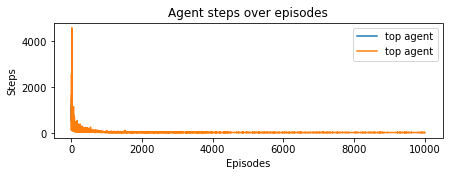

In [10]:
# Change option to 1 to save the figure. To change the file it saves to go to savefig() and adjust the first parameter. 
option = 0

fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])


for info_steps_package in step_data:
    episodes, steps = zip(*info_steps_package[0])
    axes.plot(episodes, steps, label = info_steps_package[1])
    
axes.set_xlabel('Episodes')
axes.set_ylabel('Steps')
axes.set_title("Agent steps over episodes")
axes.legend(loc=0)

if option:
    fig.savefig('Steps.jpeg', figsize = (6,2))

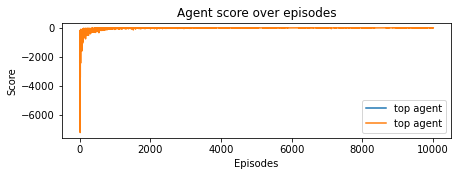

In [11]:
# Same stuff applies here
option = 0

fig = plt.figure()
axes = fig.add_axes([0.0,0.4,0.9,0.4])


for info_score_package in score_data:
    episodes, score = zip(*info_score_package[0])
    axes.plot(episodes, score, label = info_score_package[1])
    
axes.set_xlabel('Episodes')
axes.set_ylabel('Score')
axes.set_title("Agent score over episodes")
axes.legend(loc=0)

if option:
    fig.savefig('Score.jpeg', figsize = (6,2))

Now that you have made it here you can finally view the agent in its gridworld by running the cell below. Press p to pause and unpause the replay.

In [17]:
# Adjust filename to load a specific agent that has been saved
agent.load(filename = 'agent.txt')

agent.epsilon = 0
agent.reset()
gw.reset()

pygame.init()
pygame.display.set_caption('Gridworld Viewer')
gameDisplay = pygame.display.set_mode((800,600))

state  = gw.return_state()
action = agent.choose_action(state)
agent.set_init_values(state, action)

run = True
paused = False
while run:

    # Human interaction
    for event in pygame.event.get():
        if event.type == QUIT:
            run = False
        elif event.type == KEYDOWN:
            if event.key == pygame.K_SPACE:
                run = False
            elif event.key == pygame.K_p:
                if paused:
                    paused = False
                else: 
                    paused = True
    if paused:
        #Do something
        pygame.time.wait(250)
        continue

    #Game Logic
    gw.set_movement(action)
    gw.update()
    reward = gw.reward
        
    state = gw.return_state()
    action = agent.choose_action(state)
    #agent.update(state, action, reward, debug = True)
    
    if gw.terminal:
        gw.reset()
        agent.reset()
        
        state  = gw.return_state()
        action = agent.choose_action(state)
        agent.set_init_values(state, action)
        
        gameDisplay.fill((0,0,0))
        pv.show_text(gameDisplay, "Done", topleft = (200,200))
        pygame.display.update()
        pygame.time.wait(200)

    #Visuals
    gameDisplay.fill((0,0,0))
    gw.draw(gameDisplay)
    pygame.display.update()

    pygame.time.wait(200)

pygame.quit()

agent.epsilon = agent.min_epsilon

Thanks for taking the time to look at my project!

In [18]:
q = agent.q_table.copy()

In [19]:
v = q.max(axis=1).reshape(10,10)

In [20]:
for i in range(10):
    for j in range(10):
        v[i][j] = round(v[i][j],0)

In [21]:
v

array([[-17., -16., -15., -14.,   1., -10.,  -9.,  -7.,  -0.,   1.],
       [-17., -17.,   1., -13., -12., -10.,   1.,  -6.,  -0.,   1.],
       [-18., -17., -16., -14.,   0.,  -9.,   1.,  -3.,  -2.,  -1.],
       [-19.,  -0.,   0.,   1.,  -8.,  -8.,  -6.,  -5.,  -0.,  -2.],
       [-20., -18., -19.,   2.,   1.,   2.,   1.,   0.,  -4.,  -3.],
       [  2., -17.,   2., -12., -10.,  -9.,  -8.,  -7.,  -5.,  -4.],
       [-17., -15., -14., -13.,   1.,   0.,   0.,   0.,   0.,  -6.],
       [-18.,   0., -16., -14., -15., -14., -13., -11., -10.,  -8.],
       [-18., -17., -17.,   1., -15.,   2., -13., -12.,   1., -10.],
       [-17., -17., -17., -16., -15., -14., -13., -13., -12., -11.]])

In [22]:
gw.make_gridworld()